In [11]:
# Imports
import os
import requests
import pandas as pd
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
from datetime import datetime
from dateutil.relativedelta import *
import hvplot.pandas
import matplotlib.pyplot as plt
import holoviews as hv
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from finta import TA
from transformers import pipeline
# To show a progress bar when doing lengthy operations
from tqdm.notebook import tqdm

In [12]:
# Establish constants and retrieve environment variables
NEWS_FILE = './data/news.csv'

# Retrieve alpaca credentials
load_dotenv()
alpaca_api_key = os.getenv('APCA-API-KEY-ID')
alpaca_secret_key = os.getenv('APCA-API-SECRET-KEY')
if not(alpaca_api_key) or not(alpaca_secret_key):
    print('Failed to load API credentials')

In [13]:
# Get historical OHLCV data for target ticker if the data is not already stored in a csv
etf_df = yf.download(
    "STW.AX, VAS.AX, SPY.AX", 
    period="max"
)

[*********************100%***********************]  3 of 3 completed


In [15]:
# Review data to see the date ranges
display(etf_df.head())
display(etf_df.tail())
display(etf_df.shape)
display(etf_df.index)

Adj Close                    Close                     High  \
              SPY.AX     STW.AX VAS.AX SPY.AX     STW.AX VAS.AX SPY.AX   
Date                                                                     
2008-01-02       NaN  61.169998    NaN    NaN  61.169998    NaN    NaN   
2008-01-03       NaN  60.590000    NaN    NaN  60.590000    NaN    NaN   
2008-01-04       NaN  60.740002    NaN    NaN  60.740002    NaN    NaN   
2008-01-07       NaN  59.349998    NaN    NaN  59.349998    NaN    NaN   
2008-01-08       NaN  59.020000    NaN    NaN  59.020000    NaN    NaN   

                                Low                     Open             \
               STW.AX VAS.AX SPY.AX     STW.AX VAS.AX SPY.AX     STW.AX   
Date                                                                      
2008-01-02  61.169998    NaN    NaN  61.169998    NaN    NaN  61.169998   
2008-01-03  60.590000    NaN    NaN  60.590000    NaN    NaN  60.590000   
2008-01-04  60.740002    NaN    NaN  60.740002    NaN    NaN  60.740002   
2008-01-07  59.349998    NaN    NaN  59.349998    NaN    NaN  59.349998   
2008-01-08  59.020000    NaN    NaN  59.020000    NaN    NaN  59.020000   

                  Volume                
           VAS.AX SPY.AX STW.AX VAS.AX  
Date                                    
2008-01-02    NaN    NaN      0    NaN  
2008-01-03    NaN    NaN      0    NaN  
2008-01-04    NaN    NaN      0    NaN  
2008-01-07    NaN    NaN      0    NaN  
2008-01-08    NaN    NaN      0    NaN

Adj Close                             Close             \
                SPY.AX     STW.AX     VAS.AX      SPY.AX     STW.AX   
Date                                                                  
2023-01-04  560.500000  63.619999  87.190002  560.500000  63.619999   
2023-01-05  563.140015  63.779999  87.320000  563.140015  63.779999   
2023-01-06  563.669983  64.169998  87.870003  563.669983  64.169998   
2023-01-09  562.090027  64.519997  88.400002  562.090027  64.519997   
2023-01-10  560.419983  64.330002  88.139999  560.419983  64.330002   

                             High                               Low  \
               VAS.AX      SPY.AX     STW.AX     VAS.AX      SPY.AX   
Date                                                                  
2023-01-04  87.190002  567.000000  63.700001  87.199997  560.500000   
2023-01-05  87.320000  563.140015  64.080002  87.779999  561.000000   
2023-01-06  87.870003  563.750000  64.239998  87.970001  561.669983   
2023-01-09  88.400002  565.000000  64.849998  88.849998  561.210022   
2023-01-10  88.139999  561.840027  64.529999  88.419998  559.500000   

                                        Open                       Volume  \
               STW.AX     VAS.AX      SPY.AX     STW.AX     VAS.AX SPY.AX   
Date                                                                        
2023-01-04  63.060001  86.309998  564.950012  63.080002  86.389999   90.0   
2023-01-05  63.650002  87.150002  561.830017  63.900002  87.500000  127.0   
2023-01-06  63.720001  87.290001  563.030029  63.750000  87.389999  696.0   
2023-01-09  64.489998  88.330002  564.200012  64.660004  88.559998  220.0   
2023-01-10  64.300003  88.050003  561.630005  64.459999  88.300003  147.0   

                              
            STW.AX    VAS.AX  
Date                          
2023-01-04   70793  113157.0  
2023-01-05   49284  138744.0  
2023-01-06  142703  162973.0  
2023-01-09   49512  203066.0  
2023-01-10   36869  706717.0

(3800, 18)

DatetimeIndex(['2008-01-02', '2008-01-03', '2008-01-04', '2008-01-07',
               '2008-01-08', '2008-01-09', '2008-01-10', '2008-01-11',
               '2008-01-14', '2008-01-15',
               ...
               '2022-12-23', '2022-12-28', '2022-12-29', '2022-12-30',
               '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-09', '2023-01-10'],
              dtype='datetime64[ns]', name='Date', length=3800, freq=None)

In [16]:
# Examine the column type and check for nulls
etf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3800 entries, 2008-01-02 to 2023-01-10
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (Adj Close, SPY.AX)  2084 non-null   float64
 1   (Adj Close, STW.AX)  3800 non-null   float64
 2   (Adj Close, VAS.AX)  3463 non-null   float64
 3   (Close, SPY.AX)      2084 non-null   float64
 4   (Close, STW.AX)      3800 non-null   float64
 5   (Close, VAS.AX)      3463 non-null   float64
 6   (High, SPY.AX)       2084 non-null   float64
 7   (High, STW.AX)       3800 non-null   float64
 8   (High, VAS.AX)       3463 non-null   float64
 9   (Low, SPY.AX)        2084 non-null   float64
 10  (Low, STW.AX)        3800 non-null   float64
 11  (Low, VAS.AX)        3463 non-null   float64
 12  (Open, SPY.AX)       2084 non-null   float64
 13  (Open, STW.AX)       3800 non-null   float64
 14  (Open, VAS.AX)       3463 non-null   float64
 15  (Volume, SPY.AX)    

# Technical indicators
## 1. Dual Moving Average Crossover

In [17]:
# Set the Window for shorter term and longer term moving average
short_window = 50
long_window = 200

## Generate entry / exit points for all 3 etf's
### Entry / exit point for SPY

In [18]:
etf_new_df = etf_df.copy()

etf_new_df.columns = etf_new_df.columns.swaplevel()

etf_new_df = etf_new_df.dropna()

etf_new_df.head()

,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX
,Adj Close,Adj Close,Adj Close,Close,Close,Close,High,High,High,Low,Low,Low,Open,Open,Open,Volume,Volume,Volume
Date,,,,,,,,,,,,,,,,,,
2014-10-13,216.729996,48.599998,65.360001,216.729996,48.599998,65.360001,218.380005,48.700001,65.500000,216.199997,48.200001,64.959999,218.149994,48.259998,65.110001,5140.0,177654,38801.0
2014-10-14,213.949997,49.119999,66.059998,213.949997,49.119999,66.059998,214.660004,49.220001,66.160004,213.949997,48.320000,65.029999,214.000000,48.340000,65.260002,3320.0,136290,28254.0
2014-10-15,217.089996,49.500000,66.480003,217.089996,49.500000,66.480003,217.089996,49.529999,66.580002,216.630005,49.029999,66.000000,216.630005,49.160000,66.059998,1230.0,164068,38596.0
2014-10-16,212.434738,49.549999,66.599998,212.434738,49.549999,66.599998,212.434738,49.599998,66.669998,212.434738,48.700001,65.459999,212.434738,49.020000,66.019997,0.0,333351,28965.0
2014-10-17,213.059998,49.779999,66.839996,213.059998,49.779999,66.839996,213.059998,50.060001,67.260002,212.419998,49.669998,66.730003,212.419998,49.730000,66.730003,1622.0,112079,26288.0


In [19]:
# Generate the fast and slow simple moving averages (50 and 200 days, respectively)

spy_etf_df = etf_new_df['SPY.AX']
spy_etf_df["Short"] = TA.SMA(spy_etf_df, short_window)
spy_etf_df["Long"] = TA.SMA(spy_etf_df, long_window)

spy_etf_df = spy_etf_df.dropna()

/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
# Geerate the entry / exit signals
spy_etf_df["Signal"] = 0.0

spy_etf_df["Signal"][short_window:] = np.where(
    spy_etf_df["Short"][short_window:] > spy_etf_df["Long"][short_window:], 1.0, 0.0
)

spy_etf_df["Entry/Exit"] = spy_etf_df["Signal"].diff()

spy_etf_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,285.339996,285.339996,285.579987,285.339996,285.579987,363.0,276.247229,259.898916,0.0,NaN
2015-07-30,288.000000,288.000000,288.350006,287.739990,288.350006,173.0,276.623629,260.255266,0.0,0.0
2015-07-31,289.040009,289.040009,289.059998,289.010010,289.010010,384.0,276.986606,260.630716,0.0,0.0
2015-08-03,288.320007,288.320007,289.010010,288.320007,289.010010,198.0,277.352406,260.986866,0.0,0.0
2015-08-04,285.500000,285.500000,285.500000,285.500000,285.500000,30.0,277.603006,261.352193,0.0,0.0


In [22]:
# Visualize entry position relative to close price
spy_entry = spy_etf_df[spy_etf_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
spy_exit = spy_etf_df[spy_etf_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
spy_security_close = spy_etf_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
spy_moving_avgs = spy_etf_df[["Short", "Long"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
spy_entry_exit_plot = spy_security_close * spy_moving_avgs * spy_entry * spy_exit
spy_entry_exit_plot.opts(title='S&P 500 Entry/Exit Dual Moving Average Crossover')

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

# Entry / Exit points for STW

In [23]:
stw_etf_df = etf_new_df['STW.AX']
stw_etf_df["Short"] = TA.SMA(stw_etf_df, short_window)
stw_etf_df["Long"] = TA.SMA(stw_etf_df, long_window)

stw_etf_df = stw_etf_df.dropna()

/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stw_etf_df["Signal"] = 0.0

stw_etf_df["Signal"][short_window:] = np.where(
    stw_etf_df["Short"][short_window:] > stw_etf_df["Long"][short_window:], 1.0, 0.0
)

stw_etf_df["Entry/Exit"] = stw_etf_df["Signal"].diff()

stw_etf_df.head()

/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,52.520000,52.520000,52.750000,52.490002,52.700001,84266,52.5274,52.61950,0.0,NaN
2015-07-30,52.919998,52.919998,52.980000,52.720001,52.799999,74214,52.5256,52.64110,0.0,0.0
2015-07-31,53.160000,53.160000,53.209999,53.020000,53.020000,54302,52.5196,52.66130,0.0,0.0
2015-08-03,52.930000,52.930000,53.250000,52.910000,53.250000,36108,52.5074,52.67845,0.0,0.0
2015-08-04,53.150002,53.150002,53.480000,52.799999,52.950001,1688292,52.4904,52.69645,0.0,0.0


In [25]:
# Visualize entry position relative to close price
stw_entry = stw_etf_df[stw_etf_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
stw_exit = stw_etf_df[stw_etf_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
stw_security_close = stw_etf_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
stw_moving_avgs = stw_etf_df[["Short", "Long"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
stw_entry_exit_plot = stw_security_close * stw_moving_avgs * stw_entry * stw_exit
stw_entry_exit_plot.opts(title='ASX200 Entry/Exit Dual Moving Average Crossover')

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

# Entry / exit points for VAS

In [26]:
vas_etf_df = etf_new_df['VAS.AX']
vas_etf_df["Short"] = TA.SMA(vas_etf_df, short_window)
vas_etf_df["Long"] = TA.SMA(vas_etf_df, long_window)

vas_etf_df = vas_etf_df.dropna()

/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
vas_etf_df["Signal"] = 0.0

vas_etf_df["Signal"][short_window:] = np.where(
    vas_etf_df["Short"][short_window:] > vas_etf_df["Long"][short_window:], 1.0, 0.0
)

vas_etf_df["Entry/Exit"] = vas_etf_df["Signal"].diff()

vas_etf_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,71.370003,71.370003,71.769997,71.250000,71.449997,30067.0,71.2740,71.27085,0.0,NaN
2015-07-30,71.959999,71.959999,71.959999,71.410004,71.410004,39040.0,71.2814,71.30385,0.0,0.0
2015-07-31,72.099998,72.099998,72.260002,72.000000,72.000000,36925.0,71.2794,71.33405,0.0,0.0
2015-08-03,71.949997,71.949997,72.489998,71.889999,72.489998,45618.0,71.2732,71.36140,0.0,0.0
2015-08-04,72.269997,72.269997,72.599998,71.849998,72.010002,64205.0,71.2596,71.38975,0.0,0.0


In [28]:
# Visualize entry position relative to close price
vas_entry = vas_etf_df[vas_etf_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
vas_exit = vas_etf_df[vas_etf_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
vas_security_close = vas_etf_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
vas_moving_avgs = vas_etf_df[["Short", "Long"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
vas_entry_exit_plot = vas_security_close * vas_moving_avgs * vas_entry * vas_exit
vas_entry_exit_plot.opts(title='Vanguard Entry/Exit Dual Moving Average Crossover')

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## 2. Using bolinger bands for entry / exit signals

In [29]:
# Bolinger Band signals for SPY

spy_bb_signals_df = spy_etf_df.copy()
spy_bb_signals_df.head()



,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,285.339996,285.339996,285.579987,285.339996,285.579987,363.0,276.247229,259.898916,0.0,NaN
2015-07-30,288.000000,288.000000,288.350006,287.739990,288.350006,173.0,276.623629,260.255266,0.0,0.0
2015-07-31,289.040009,289.040009,289.059998,289.010010,289.010010,384.0,276.986606,260.630716,0.0,0.0
2015-08-03,288.320007,288.320007,289.010010,288.320007,289.010010,198.0,277.352406,260.986866,0.0,0.0
2015-08-04,285.500000,285.500000,285.500000,285.500000,285.500000,30.0,277.603006,261.352193,0.0,0.0


In [30]:
# Determine the Bollinger Bands for the Dataset
spy_bbands_df = TA.BBANDS(spy_bb_signals_df)

# Review the DataFrame

spy_bbands_df = spy_bbands_df.dropna()
spy_bbands_df.head()

,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,
2015-08-25,295.791124,283.294333,270.797542
2015-08-26,297.477418,282.197833,266.918249
2015-08-27,296.923052,281.514833,266.106614
2015-08-28,296.020579,280.941832,265.863085
2015-08-31,295.136009,280.390332,265.644655


In [31]:
# Concatenate the Bollinger Bands to the DataFrame
spy_bb_signals_df = pd.concat([spy_bb_signals_df, spy_bbands_df], axis=1)
spy_bb_signals_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,,,,,,,,,,,
2015-07-29,285.339996,285.339996,285.579987,285.339996,285.579987,363.0,276.247229,259.898916,0.0,NaN,NaN,NaN,NaN
2015-07-30,288.000000,288.000000,288.350006,287.739990,288.350006,173.0,276.623629,260.255266,0.0,0.0,NaN,NaN,NaN
2015-07-31,289.040009,289.040009,289.059998,289.010010,289.010010,384.0,276.986606,260.630716,0.0,0.0,NaN,NaN,NaN
2015-08-03,288.320007,288.320007,289.010010,288.320007,289.010010,198.0,277.352406,260.986866,0.0,0.0,NaN,NaN,NaN
2015-08-04,285.500000,285.500000,285.500000,285.500000,285.500000,30.0,277.603006,261.352193,0.0,0.0,NaN,NaN,NaN


In [33]:
# Visualize close price for the investment
spy_sec_close = spy_bb_signals_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

spy_bb_upper = spy_bb_signals_df[["BB_UPPER"]].hvplot(
    line_color='purple',
    ylabel='Price in $',
    width=1000,
    height=400
)


spy_bb_middle = spy_bb_signals_df[["BB_MIDDLE"]].hvplot(
    line_color='orange',
    ylabel='Price in $',
    width=1000,
    height=400
)

spy_bb_lower = spy_bb_signals_df[["BB_LOWER"]].hvplot(
    line_color='blue',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
spy_bbands_plot = spy_sec_close * spy_bb_upper * spy_bb_middle * spy_bb_lower * spy_entry * spy_exit
spy_bbands_plot.opts(title='S&P 500 Entry/Exit Based on Bolinger Bands')

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Curve.II         :Curve   [Date]   (BB_UPPER)
   .Curve.III        :Curve   [Date]   (BB_MIDDLE)
   .Curve.IV         :Curve   [Date]   (BB_LOWER)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [34]:
# Bolinger Band signals for STW

stw_bb_signals_df = stw_etf_df.copy()
stw_bb_signals_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,52.520000,52.520000,52.750000,52.490002,52.700001,84266,52.5274,52.61950,0.0,NaN
2015-07-30,52.919998,52.919998,52.980000,52.720001,52.799999,74214,52.5256,52.64110,0.0,0.0
2015-07-31,53.160000,53.160000,53.209999,53.020000,53.020000,54302,52.5196,52.66130,0.0,0.0
2015-08-03,52.930000,52.930000,53.250000,52.910000,53.250000,36108,52.5074,52.67845,0.0,0.0
2015-08-04,53.150002,53.150002,53.480000,52.799999,52.950001,1688292,52.4904,52.69645,0.0,0.0


In [35]:
# Determine the Bollinger Bands for the Dataset
stw_bbands_df = TA.BBANDS(stw_bb_signals_df)

# Review the DataFrame

stw_bbands_df = stw_bbands_df.dropna()
stw_bbands_df.head()

,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,
2015-08-25,54.434940,50.8880,47.341060
2015-08-26,54.292056,50.6920,47.091944
2015-08-27,54.002467,50.5095,47.016532
2015-08-28,53.612133,50.3265,47.040867
2015-08-31,53.224824,50.1295,47.034176


In [36]:
# Concatenate the Bollinger Bands to the DataFrame

stw_bb_signals_df = pd.concat([stw_bb_signals_df, stw_bbands_df], axis=1)
stw_bb_signals_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,,,,,,,,,,,
2015-07-29,52.520000,52.520000,52.750000,52.490002,52.700001,84266,52.5274,52.61950,0.0,NaN,NaN,NaN,NaN
2015-07-30,52.919998,52.919998,52.980000,52.720001,52.799999,74214,52.5256,52.64110,0.0,0.0,NaN,NaN,NaN
2015-07-31,53.160000,53.160000,53.209999,53.020000,53.020000,54302,52.5196,52.66130,0.0,0.0,NaN,NaN,NaN
2015-08-03,52.930000,52.930000,53.250000,52.910000,53.250000,36108,52.5074,52.67845,0.0,0.0,NaN,NaN,NaN
2015-08-04,53.150002,53.150002,53.480000,52.799999,52.950001,1688292,52.4904,52.69645,0.0,0.0,NaN,NaN,NaN


In [37]:
# Visualize close price for the investment
stw_sec_close = stw_bb_signals_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

stw_bb_upper = stw_bb_signals_df[["BB_UPPER"]].hvplot(
    line_color='purple',
    ylabel='Price in $',
    width=1000,
    height=400
)

stw_bb_middle = stw_bb_signals_df[["BB_MIDDLE"]].hvplot(
    line_color='orange',
    ylabel='Price in $',
    width=1000,
    height=400
)

stw_bb_lower = stw_bb_signals_df[["BB_LOWER"]].hvplot(
    line_color='blue',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
stw_bbands_plot = stw_sec_close * stw_bb_upper * stw_bb_middle * stw_bb_lower * stw_entry * stw_exit
stw_bbands_plot.opts(title='ASX200 Entry/Exit Based on Bolinger Bands')

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Curve.II         :Curve   [Date]   (BB_UPPER)
   .Curve.III        :Curve   [Date]   (BB_MIDDLE)
   .Curve.IV         :Curve   [Date]   (BB_LOWER)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [38]:
# Bolinger Band signals for VAS

vas_bb_signals_df = vas_etf_df.copy()
vas_bb_signals_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,71.370003,71.370003,71.769997,71.250000,71.449997,30067.0,71.2740,71.27085,0.0,NaN
2015-07-30,71.959999,71.959999,71.959999,71.410004,71.410004,39040.0,71.2814,71.30385,0.0,0.0
2015-07-31,72.099998,72.099998,72.260002,72.000000,72.000000,36925.0,71.2794,71.33405,0.0,0.0
2015-08-03,71.949997,71.949997,72.489998,71.889999,72.489998,45618.0,71.2732,71.36140,0.0,0.0
2015-08-04,72.269997,72.269997,72.599998,71.849998,72.010002,64205.0,71.2596,71.38975,0.0,0.0


In [39]:
# Determine the Bollinger Bands for the Dataset
vas_bbands_df = TA.BBANDS(vas_bb_signals_df)

# Review the DataFrame

vas_bbands_df = vas_bbands_df.dropna()
vas_bbands_df.head()

,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,
2015-08-25,73.915879,69.2700,64.624121
2015-08-26,73.744569,69.0085,64.272431
2015-08-27,73.361367,68.7640,64.166633
2015-08-28,72.882392,68.5290,64.175608
2015-08-31,72.382068,68.2600,64.137933


In [40]:
# Concatenate the Bollinger Bands to the DataFrame

vas_bb_signals_df = pd.concat([vas_bb_signals_df, vas_bbands_df], axis=1)
vas_bb_signals_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,,,,,,,,,,,
2015-07-29,71.370003,71.370003,71.769997,71.250000,71.449997,30067.0,71.2740,71.27085,0.0,NaN,NaN,NaN,NaN
2015-07-30,71.959999,71.959999,71.959999,71.410004,71.410004,39040.0,71.2814,71.30385,0.0,0.0,NaN,NaN,NaN
2015-07-31,72.099998,72.099998,72.260002,72.000000,72.000000,36925.0,71.2794,71.33405,0.0,0.0,NaN,NaN,NaN
2015-08-03,71.949997,71.949997,72.489998,71.889999,72.489998,45618.0,71.2732,71.36140,0.0,0.0,NaN,NaN,NaN
2015-08-04,72.269997,72.269997,72.599998,71.849998,72.010002,64205.0,71.2596,71.38975,0.0,0.0,NaN,NaN,NaN


In [41]:
# Visualize close price for the investment
vas_sec_close = vas_bb_signals_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=900,
    height=400
)

vas_bb_upper = vas_bb_signals_df[["BB_UPPER"]].hvplot(
    line_color='purple',
    ylabel='Price in $',
    width=900,
    height=400
)


vas_bb_middle = vas_bb_signals_df[["BB_MIDDLE"]].hvplot(
    line_color='orange',
    ylabel='Price in $',
    width=900,
    height=400
)

vas_bb_lower = vas_bb_signals_df[["BB_LOWER"]].hvplot(
    title = "Bollingers Bands Signals for VAS",
    line_color='blue',
    ylabel='Price in $',
    width=900,
    height=400
)

# Overlay plots
vas_bbands_plot = vas_sec_close * vas_bb_upper * vas_bb_middle * vas_bb_lower * vas_entry * vas_exit
vas_bbands_plot.opts(title='Vanguard Entry/Exit Based on Bolinger Bands')



:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Curve.II         :Curve   [Date]   (BB_UPPER)
   .Curve.III        :Curve   [Date]   (BB_MIDDLE)
   .Curve.IV         :Curve   [Date]   (BB_LOWER)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

# Natural language processing
## This section will attempt to determine sentiment analysis from news headlines
### Approach
1. For each ETF, find the top 10 tickers by market cap
2. Retrieve the news headline for each ticker for each day in the dataset
3. Convert each headline to a sentiment indicating `negative`, `neutral` or `positive` using:
  3.1. distilRoberta-financial-sentiment
  3.2. This model is a fine-tuned version of `distilroberta-base` on the `financial_phrasebank` dataset. It achieves the following results on the evaluation set:
  3.3.    Loss: 0.1116
  3.4.    Accuracy: 0.9823
4. If there are multiple headlines for a day, retain the most frequent sentiment

In [42]:
# Collect the top 10 stocks of the Vangard to use as proxy for the SPY.AX ETF
# Note - hardcoding the stocks as there does not appear to be an easier way to 
# programitcally retrieve the constituent stocks
spy_top10 = [
    {
        'symbol': 'AAPL',
        'description': 'Apple'
    }, 
    {
        'symbol': 'MSFT',
        'description': 'Microsoft' 
    },
    {
        'symbol': 'AMZN',
        'description': 'Amazon' 
    },
    {
        'symbol': 'TSLA',
        'description': 'Tesla' 
    },
    {
        'symbol': 'GOOGL',
        'description': 'Google'  
    },
    {
        'symbol': 'GOOG', 
        'description': 'Google'
    },
    {
        'symbol': 'NVDA', 
        'description': 'Nvidia'
    },
    {
        'symbol': 'BRK.B', 
        'description': 'Berkshire'
    },
    {
        'symbol': 'META', 
        'description': 'Meta'
    },
    {
        'symbol': 'UNH',
        'description': 'United Health'
    }
]

In [43]:
# Collect the top 10 stocks of the Vanguard fund to use as proxy for the VAS.AX ETF
# Note - hardcoding the stocks as there does not appear to be an easier way to 
# programitcally retrieve the vanguarg constituent stocks
vas_top10 = [
    {
        'symbol': 'BHP',
        'description': 'BHP'
    }, 
    {
        'symbol': 'CBA',
        'description': 'Commonwealth Bank' 
    },
    {
        'symbol': 'CSL',
        'description': 'CSL' 
    },
    {
        'symbol': 'NAB',
        'description': 'NAB' 
    },
    {
        'symbol': 'NAB',
        'description': 'National Australia Bank'
    },
    {
        'symbol': 'WBC',
        'description': 'Westpac'  
    },
    {
        'symbol': 'ANZDA', 
        'description': 'ANZ Bank'
    },
    {
        'symbol': 'WDS', 
        'description': 'Woodside'
    },
    {
        'symbol': 'MQG', 
        'description': 'Macquarie Group'
    },
    {
        'symbol': 'WES', 
        'description': 'Wesfarmers'
    },
    {
        'symbol': 'TLS',
        'description': 'Telstra'
    }
]

In [44]:
# Collect the top 10 stocks of the ASX 200 to use as proxy for the STW.AX ETF
# Note - hardcoding the stocks as there does not appear to be an easier way to 
# programitcally retrieve the constituent stocks
stw_top10 = [
    {
        'symbol': 'BHP',
        'description': 'BHP'
    }, 
    {
        'symbol': 'CBA',
        'description': 'Commonwealth Bank' 
    },
    {
        'symbol': 'CSL',
        'description': 'CSL' 
    },
    {
        'symbol': 'NAB',
        'description': 'NAB' 
    },
    {
        'symbol': 'NAB',
        'description': 'National Australia Bank'
    },
    {
        'symbol': 'WBC',
        'description': 'Westpac'  
    },
    {
        'symbol': 'ANZDA', 
        'description': 'ANZ Bank'
    },
    {
        'symbol': 'WDS', 
        'description': 'Woodside'
    },
    {
        'symbol': 'MQG', 
        'description': 'Macquarie Group'
    },
    {
        'symbol': 'WES', 
        'description': 'Wesfarmers'
    },
    {
        'symbol': 'TLS',
        'description': 'Telstra'
    }
]

In [45]:
# Check to see if we already have some data on disk
news_path = Path(NEWS_FILE)
news_path.is_file()

True

In [46]:
def retrieve_news():

    # Create an empty dataframe to receive the news
    buzz_df = pd.DataFrame()

    # Prepare to retrieve news from alpaca
    alpaca_endpoint = 'https://data.alpaca.markets/v1beta1/news'

    alpaca_headers = {
        'Apca-Api-Key-Id': alpaca_api_key,
        'Apca-Api-Secret-Key': alpaca_secret_key
    }
    
    parameters = {
        'symbols': spy_top10[0]['symbol'],
        'start': pd.to_datetime(etf_df.index[0]).strftime('%Y-%m-%d'),
        'end': pd.to_datetime(etf_df.index[-1]).strftime('%Y-%m-%d'),
        'limit': 50,
        'include_content': False,
    }

    response = requests.get(
        url = alpaca_endpoint,
        headers = alpaca_headers,
        params = parameters
    )

    response.raise_for_status()

    # Unpack the news from response
    news_page = pd.DataFrame(response.json()['news'])

    # Create a news dataframe
    # news_df = news_page.loc[news_page['headline'].str.contains(spy_top10[0]['description'], na=False, case=False)]
    buzz_df = buzz_df.append(news_page, ignore_index=True)

    # Loop through all the remaining news data
    while(response.json()['next_page_token'] != None):
        parameters['page_token'] = response.json()['next_page_token']

        response = requests.get(
            url = alpaca_endpoint,
            headers = alpaca_headers,
            params = parameters
        )

        response.raise_for_status()

        news_page = pd.DataFrame(response.json()['news'])
        # print(f"{news_page.iloc[-1]['headline']}")
        buzz_df = buzz_df.append(news_page, ignore_index=True)
    
    # Save data to csv as downloading from alpaca can take up to 10 minutes
    buzz_df.to_csv(Path('./data/news.csv'), index=False)

    # And return the dataframe to the caller
    return buzz_df

In [47]:
# Get the news for the historical period from file or from alpaca news API
news_df = pd.DataFrame()
if news_path.is_file():
    news_df = pd.read_csv(news_path)
else:
    news_df = retrieve_news()


In [48]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   author      21503 non-null  object 
 1   content     0 non-null      float64
 2   created_at  21503 non-null  object 
 3   headline    21503 non-null  object 
 4   id          21503 non-null  int64  
 5   images      21503 non-null  object 
 6   source      4250 non-null   object 
 7   summary     6226 non-null   object 
 8   symbols     21503 non-null  object 
 9   updated_at  21503 non-null  object 
 10  url         21503 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.8+ MB


In [49]:
# Cast `news_df` column types to proper data types so that future df merges will work
news_df = news_df.astype(
    {
        'author': 'string',
        'content': 'string',
        'created_at': 'string',
        'headline': 'string',
        'images': 'string',
        'source': 'string',
        'symbols': 'string',
        'summary': 'string',
        'updated_at': 'string',
        'url': 'string'
    }
)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   author      21503 non-null  string
 1   content     0 non-null      string
 2   created_at  21503 non-null  string
 3   headline    21503 non-null  string
 4   id          21503 non-null  int64 
 5   images      21503 non-null  string
 6   source      4250 non-null   string
 7   summary     6226 non-null   string
 8   symbols     21503 non-null  string
 9   updated_at  21503 non-null  string
 10  url         21503 non-null  string
dtypes: int64(1), string(10)
memory usage: 1.8 MB


In [50]:
len(news_df)

21503

In [51]:
# Establish a `Transformers` pipeline for NLP based on the `distilroberta`-base on the financial_phrasebank dataset
etf_pipeline = pipeline(model='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis')

In [52]:
# Filter the news dataset for items related to SPY stocks
spy_df = pd.DataFrame(columns=news_df.columns)
for i in range(len(spy_top10)):
    subset_df = news_df.loc[
        news_df['headline'].str.contains(spy_top10[i]['description'], na=False, case=False)
    ]
    spy_df = pd.merge(spy_df, subset_df, how='outer')


In [53]:
# Add new column for SPY sentiment
spy_df['SPY_Sentiment'] = np.NaN


In [54]:
# Using the `Transformers` model, add a sentiment flag for each headline
for i, row in tqdm(spy_df.iterrows(), total=len(spy_df)):
    sentiment = etf_pipeline(row['headline'])
    if sentiment[0]['label'] == 'negative':
        sentiment_flag = -1.0
    elif sentiment[0]['label'] == 'positive':
        sentiment_flag = 1.0
    else:
        sentiment_flag = 0.0
    spy_df._set_value(i, 'SPY_Sentiment', sentiment_flag) 

  0%|          | 0/13885 [00:00<?, ?it/s]

In [55]:
spy_df.iloc[10].headline

'Apple Currently Has No Plans To Re-Introduce The iPhone 15 mini In 2023'

In [56]:
etf_pipeline(spy_df.iloc[10].headline)

[{'label': 'neutral', 'score': 0.9998736381530762}]

In [57]:
spy_df.head()

,author,content,created_at,headline,id,images,source,summary,symbols,updated_at,url,SPY_Sentiment
0,Chris Katje,<NA>,2023-01-03T23:54:34Z,EXCLUSIVE: Top 10 Searched Tickers On Benzinga...,30267286,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Each trading day features hundreds of headline...,"['AAPL', 'AMAM', 'AMC', 'AMZN', 'ATNF', 'CEI',...",2023-01-03T23:54:34Z,https://www.benzinga.com/general/biotech/23/01...,0.0
1,Benzinga Insights,<NA>,2023-01-03T19:00:16Z,What 15 Analyst Ratings Have To Say About Apple,30262627,[],benzinga,,['AAPL'],2023-01-03T19:00:16Z,https://www.benzinga.com/analyst-ratings/23/01...,0.0
2,Adam Eckert,<NA>,2023-01-03T18:26:06Z,Why Apple Stock Is Falling Today,30261999,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Apple Inc (NASDAQ: AAPL) shares are making new...,['AAPL'],2023-01-03T18:26:06Z,https://www.benzinga.com/trading-ideas/movers/...,-1.0
3,Adam Eckert,<NA>,2023-01-03T16:01:56Z,Apple Tells Suppliers To Build Fewer Component...,30258995,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Apple Inc (NASDAQ: AAPL) shares slid into the ...,"['AAPL', 'FOSL', 'HNHPF', 'QCOM', 'SSNNF', 'SW...",2023-01-03T16:01:57Z,https://www.benzinga.com/news/23/01/30258995/a...,-1.0
4,Benzinga Newsdesk,<NA>,2023-01-03T14:35:46Z,"Apple Said To Ask Suppliers For Fewer AirPods,...",30257892,[],benzinga,<NA>,['AAPL'],2023-01-03T14:35:46Z,https://www.benzinga.com/news/23/01/30257892/a...,0.0


In [58]:
# Filter on news related to ASX-200 stocks
stw_df = pd.DataFrame(columns=news_df.columns)
for i in range(len(stw_top10)):
    subset_df = news_df.loc[

        news_df['headline'].str.contains(stw_top10[i]['description'], na=False, case=False)
    ]
    stw_df = pd.merge(stw_df, subset_df, how='outer')

stw_df.shape

(104, 11)

In [59]:
# Add new column for STW sentiment
stw_df['STW_Sentiment'] = np.NaN

In [60]:
# Using the `Transformers` model, add a sentiment flag for each headline
for i, row in tqdm(stw_df.iterrows(), total=len(stw_df)):
    sentiment = etf_pipeline(row['headline'])
    if sentiment[0]['label'] == 'NEGATIVE':
        sentiment_flag = -1.0
    elif sentiment[0]['label'] == 'POSITIVE':
        sentiment_flag = 1.0
    else:
        sentiment_flag = 0.0
    stw_df._set_value(i, 'STW_Sentiment', sentiment_flag) 

  0%|          | 0/104 [00:00<?, ?it/s]

In [61]:
stw_df.head()

,author,content,created_at,headline,id,images,source,summary,symbols,updated_at,url,STW_Sentiment
0,Benzinga,<NA>,2018-02-22T16:49:39Z,"Cobalt Stocks Continue Higher Thurs., Potentia...",11243568,[],<NA>,<NA>,"['AAPL', 'BHP', 'FCX', 'VALE']",2018-02-22T16:49:39Z,https://www.benzinga.com/node/11243568,0.0
1,Vandana Singh,<NA>,2022-12-28T13:02:16Z,"China Relaxes Approval Of Imported Games, Goog...",30212156,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Reuters,"['AAPL', 'AMZN', 'BA', 'BABA', 'BNBUSD', 'BTCU...",2022-12-28T13:02:16Z,https://www.benzinga.com/news/large-cap/22/12/...,0.0
2,Shivdeep Dhaliwal,<NA>,2022-12-01T01:48:47Z,"After Elon Musk's Tirade, Mark Zuckerberg Slam...",29916750,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Meta Platforms Inc (NASDAQ: META) CEO Mark Zuc...,"['AAPL', 'GOOG', 'GOOGL', 'META']",2022-12-01T01:48:47Z,https://www.benzinga.com/news/22/11/29916750/a...,0.0
3,Maureen Meehan,<NA>,2022-11-25T20:09:12Z,Louis Armstrong Loved Cannabis And Didn't Care...,29844467,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,When Jazz legend and New Orleans native Louis ...,['AAPL'],2022-11-25T20:09:12Z,https://www.benzinga.com/markets/cannabis/22/1...,0.0
4,Benzinga Newsdesk,<NA>,2022-11-10T13:08:52Z,"Apple Says With Upgraded Ground Stations, Soon...",29657047,[],benzinga,<NA>,"['AAPL', 'GSAT']",2022-11-10T13:08:52Z,https://www.benzinga.com/news/22/11/29657047/a...,0.0


In [62]:
# Filter on news related to the Vanguard ETF stocks
vas_df = pd.DataFrame(columns=news_df.columns)
for i in range(len(vas_top10)):
    subset_df = news_df.loc[
        news_df['headline'].str.contains(vas_top10[i]['description'], na=False, case=False)
    ]
    vas_df = pd.merge(vas_df, subset_df, how='outer')

vas_df.shape

(104, 11)

In [63]:
# Add new column for VAS sentiment
vas_df['VAS_Sentiment'] = np.NaN

In [64]:
# Using the `Transformers` model, add a sentiment flag for each headline
for i, row in tqdm(vas_df.iterrows(), total=len(vas_df)):
    sentiment = etf_pipeline(row['headline'])
    if sentiment[0]['label'] == 'NEGATIVE':
        sentiment_flag = -1.0
    elif sentiment[0]['label'] == 'POSITIVE':
        sentiment_flag = 1.0
    else:
        sentiment_flag = 0.0
    vas_df._set_value(i, 'VAS_Sentiment', sentiment_flag) 

  0%|          | 0/104 [00:00<?, ?it/s]

In [65]:
vas_df.head()

,author,content,created_at,headline,id,images,source,summary,symbols,updated_at,url,VAS_Sentiment
0,Benzinga,<NA>,2018-02-22T16:49:39Z,"Cobalt Stocks Continue Higher Thurs., Potentia...",11243568,[],<NA>,<NA>,"['AAPL', 'BHP', 'FCX', 'VALE']",2018-02-22T16:49:39Z,https://www.benzinga.com/node/11243568,0.0
1,Vandana Singh,<NA>,2022-12-28T13:02:16Z,"China Relaxes Approval Of Imported Games, Goog...",30212156,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Reuters,"['AAPL', 'AMZN', 'BA', 'BABA', 'BNBUSD', 'BTCU...",2022-12-28T13:02:16Z,https://www.benzinga.com/news/large-cap/22/12/...,0.0
2,Shivdeep Dhaliwal,<NA>,2022-12-01T01:48:47Z,"After Elon Musk's Tirade, Mark Zuckerberg Slam...",29916750,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Meta Platforms Inc (NASDAQ: META) CEO Mark Zuc...,"['AAPL', 'GOOG', 'GOOGL', 'META']",2022-12-01T01:48:47Z,https://www.benzinga.com/news/22/11/29916750/a...,0.0
3,Maureen Meehan,<NA>,2022-11-25T20:09:12Z,Louis Armstrong Loved Cannabis And Didn't Care...,29844467,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,When Jazz legend and New Orleans native Louis ...,['AAPL'],2022-11-25T20:09:12Z,https://www.benzinga.com/markets/cannabis/22/1...,0.0
4,Benzinga Newsdesk,<NA>,2022-11-10T13:08:52Z,"Apple Says With Upgraded Ground Stations, Soon...",29657047,[],benzinga,<NA>,"['AAPL', 'GSAT']",2022-11-10T13:08:52Z,https://www.benzinga.com/news/22/11/29657047/a...,0.0


## Since only limited news data could be found for STW and VAS ETF companies, we will focus on the S&P 500 ETF instead

In [66]:
# Focusing on the S&P 500, use the `updated_at` column as index
spy_df.index = pd.to_datetime(spy_df['updated_at'])

In [67]:
# find the most frequent sentiment per day
spy_df.sort_index(inplace=True)
spy_sentiment = spy_df.groupby(spy_df.index.date)['SPY_Sentiment'] \
    .apply(lambda x: x.value_counts().sort_values(ascending=False).head(1)) \
    .to_frame()

In [68]:
spy_sentiment.reset_index(level=1, inplace=True)
spy_sentiment

,level_1,SPY_Sentiment
2015-01-02,0.0,2
2015-01-03,0.0,2
2015-01-05,0.0,1
2015-01-06,0.0,2
2015-01-07,-1.0,1
...,...,...
2022-12-28,0.0,5
2022-12-29,0.0,4
2022-12-30,0.0,3
2023-01-01,0.0,1


In [69]:
spy_sentiment = spy_sentiment.rename(columns={'SPY_Sentiment': 'Sentiment_Frequency'})
spy_sentiment = spy_sentiment.rename(columns={'level_1': 'SPY_Sentiment'})
print(spy_sentiment)

            SPY_Sentiment  Sentiment_Frequency
2015-01-02            0.0                    2
2015-01-03            0.0                    2
2015-01-05            0.0                    1
2015-01-06            0.0                    2
2015-01-07           -1.0                    1
...                   ...                  ...
2022-12-28            0.0                    5
2022-12-29            0.0                    4
2022-12-30            0.0                    3
2023-01-01            0.0                    1
2023-01-03            0.0                    5

[2360 rows x 2 columns]


<AxesSubplot:title={'center':'Sentiment Analysis Frequency - S&P 500'}>

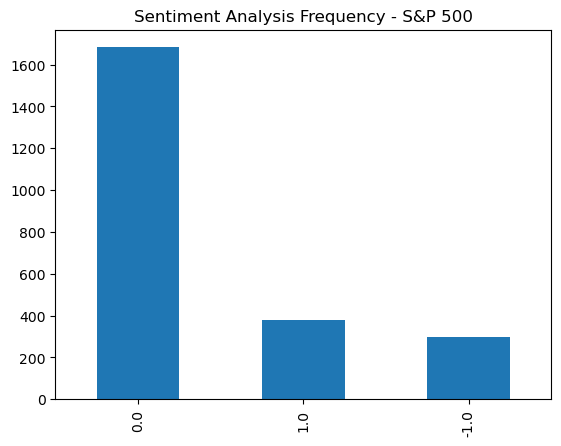

In [72]:
spy_sentiment['SPY_Sentiment'].value_counts().plot(kind='bar', title='Sentiment Analysis Frequency - S&P 500')

In [73]:
# Merge sentiment and ETF values
ETF_Sentiment = pd.concat([spy_etf_df, spy_sentiment], axis=1)
ETF_Sentiment.tail()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit,SPY_Sentiment,Sentiment_Frequency
2023-01-04,560.500000,560.500000,567.000000,560.500000,564.950012,90.0,587.085199,580.98080,1.0,0.0,NaN,NaN
2023-01-05,563.140015,563.140015,563.140015,561.000000,561.830017,127.0,586.506599,580.80150,1.0,0.0,NaN,NaN
2023-01-06,563.669983,563.669983,563.750000,561.669983,563.030029,696.0,585.791998,580.62335,1.0,0.0,NaN,NaN
2023-01-09,562.090027,562.090027,565.000000,561.210022,564.200012,220.0,585.112999,580.41950,1.0,0.0,NaN,NaN
2023-01-10,560.419983,560.419983,561.840027,559.500000,561.630005,147.0,584.521399,580.25065,1.0,0.0,NaN,NaN


In [74]:
# Remove nulls for potential days where news not available
ETF_Sentiment = ETF_Sentiment.dropna()

# Mask the `SPY_Sentiment`values for rows that don't have entry/exit signals
# ETF_Sentiment['SPY_Sentiment'] = np.where(ETF_Sentiment['Signal'] != 0.0, ETF_Sentiment['SPY_Sentiment'], np.NaN)
ETF_Sentiment.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit,SPY_Sentiment,Sentiment_Frequency
2015-07-30,288.000000,288.000000,288.350006,287.739990,288.350006,173.0,276.623629,260.255266,0.0,0.0,0.0,1.0
2015-07-31,289.040009,289.040009,289.059998,289.010010,289.010010,384.0,276.986606,260.630716,0.0,0.0,0.0,3.0
2015-08-03,288.320007,288.320007,289.010010,288.320007,289.010010,198.0,277.352406,260.986866,0.0,0.0,0.0,2.0
2015-08-04,285.500000,285.500000,285.500000,285.500000,285.500000,30.0,277.603006,261.352193,0.0,0.0,0.0,7.0
2015-08-05,285.966766,285.966766,285.966766,285.966766,285.966766,0.0,277.879941,261.716726,0.0,0.0,-1.0,6.0


In [75]:
ETF_Sentiment.loc[(ETF_Sentiment['Entry/Exit'] == 0.0),['SPY_Sentiment']] = np.NaN
ETF_Sentiment.loc[(ETF_Sentiment['Entry/Exit'] != 0.0)]

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit,SPY_Sentiment,Sentiment_Frequency
2015-10-07,274.700012,274.700012,275.709991,274.700012,275.709991,3525.0,278.655781,270.862172,1.0,1.0,1.0,1.0
2016-02-09,262.709991,262.709991,262.750000,262.279999,262.750000,100.0,278.363545,278.431330,0.0,-1.0,-1.0,2.0
2016-06-14,281.970001,281.970001,282.000000,281.720001,282.000000,29.0,277.950018,277.769926,1.0,1.0,0.0,11.0
2017-09-12,311.209991,311.209991,311.209991,310.739990,310.739990,83.0,311.376501,311.380883,0.0,-1.0,0.0,37.0
2017-10-11,326.320007,326.320007,326.320007,326.320007,326.320007,10.0,313.261548,313.050820,1.0,1.0,0.0,4.0
2018-12-27,348.010010,348.010010,348.010010,348.000000,348.000000,465.0,372.680201,373.386550,0.0,-1.0,0.0,2.0
2019-03-20,398.429993,398.429993,398.429993,397.640015,397.640015,65.0,381.191400,380.784800,1.0,1.0,0.0,1.0
2020-04-22,435.929993,435.929993,440.000000,432.480011,440.000000,1005.0,446.623399,447.849150,0.0,-1.0,1.0,1.0
2020-08-24,475.269989,475.269989,475.269989,474.720001,475.000000,52.0,456.869999,456.256300,1.0,1.0,1.0,3.0
2022-03-23,602.859985,602.859985,603.460022,600.479980,600.479980,104.0,610.589000,611.134400,0.0,-1.0,0.0,5.0


In [78]:
# Visualize entry position relative to close price
spy_etf_entry = ETF_Sentiment[ETF_Sentiment["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
spy_etf_exit = ETF_Sentiment[ETF_Sentiment["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualise the entry position based on sentiment analysis
spy_nlp_entry = ETF_Sentiment[ETF_Sentiment["SPY_Sentiment"] == 1.0]["Close"].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualise the exit position based on sentiment analysis
spy_nlp_exit = ETF_Sentiment[ETF_Sentiment["SPY_Sentiment"] == -1.0]["Close"].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualise the neutral position based on sentiment analysis
spy_nlp_neu = ETF_Sentiment[ETF_Sentiment["SPY_Sentiment"] == 0.0]["Close"].hvplot.scatter(
    color='cyan',
    marker='o',
    size=100,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
spy_security_nlp_close = ETF_Sentiment[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
spy_moving_nlp_avgs = ETF_Sentiment[["Short", "Long"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
spy_entry_exit_nlp_plot = spy_etf_entry * spy_etf_exit * spy_nlp_neu * spy_security_nlp_close * spy_moving_nlp_avgs * spy_nlp_entry * spy_nlp_exit 
spy_entry_exit_nlp_plot.opts(title='S&P 500 Entry/Exit vs NLP Sentiment Analysis')

:Overlay
   .Scatter.Close.I   :Scatter   [index]   (Close)
   .Scatter.Close.II  :Scatter   [index]   (Close)
   .Scatter.Close.III :Scatter   [index]   (Close)
   .Curve.I           :Curve   [index]   (Close)
   .NdOverlay.I       :NdOverlay   [Variable]
      :Curve   [index]   (value)
   .Scatter.Close.IV  :Scatter   [index]   (Close)
   .Scatter.Close.V   :Scatter   [index]   (Close)